# Hail Conv Net Filter Activations

This notebook contains the examples that activate each convolutional filter in the last layer of a hail neural net.

In [1]:
% matplotlib inline
import numpy as np
import pandas as pd
import keras.backend as K
from keras.models import load_model
import matplotlib.pyplot as plt
import xarray as xr
from deepsky.data import load_storm_patch_data
from deepsky.gan import normalize_multivariate_data, unnormalize_multivariate_data
from deepsky.importance import activated_analogs
from scipy.ndimage import gaussian_filter
import yaml
from os.path import join, exists

In [2]:
config_file = "/users/dgagne/deepsky/config/spatial_storm_model_config.yaml"
with open(config_file) as config_obj:
    config = yaml.load(config_obj)

Load storm data from netCDF and normalize it.

In [3]:
data_path = "/users/dgagne/ncar_control_storm_patches/"
input_variables = config["input_variables"]
num_proc = 4
print("Loading data")
storm_data, storm_meta = load_storm_patch_data(data_path, input_variables, num_proc)
storm_norm_data, storm_scaling_values = normalize_multivariate_data(storm_data)

Loading data
/users/dgagne/ncar_control_storm_patches/ncar_ens_storm_patches_2016050500_mem_01.nc 255
/users/dgagne/ncar_control_storm_patches/ncar_ens_storm_patches_2016050400_mem_01.nc 460
/users/dgagne/ncar_control_storm_patches/ncar_ens_storm_patches_2016050300_mem_01.nc 640
/users/dgagne/ncar_control_storm_patches/ncar_ens_storm_patches_2016050600_mem_01.nc 935
/users/dgagne/ncar_control_storm_patches/ncar_ens_storm_patches_2016050700_mem_01.nc 850
/users/dgagne/ncar_control_storm_patches/ncar_ens_storm_patches_2016050800_mem_01.nc 1300
/users/dgagne/ncar_control_storm_patches/ncar_ens_storm_patches_2016050900_mem_01.nc 1935
/users/dgagne/ncar_control_storm_patches/ncar_ens_storm_patches_2016051200_mem_01.nc 1015
/users/dgagne/ncar_control_storm_patches/ncar_ens_storm_patches_2016051000_mem_01.nc 2010
/users/dgagne/ncar_control_storm_patches/ncar_ens_storm_patches_2016051500_mem_01.nc 690
/users/dgagne/ncar_control_storm_patches/ncar_ens_storm_patches_2016051400_mem_01.nc 765
/use

In [4]:
model_path = "/scratch/dgagne/spatial_storm_results_20171220/"
sample = 3
hail_cnn = load_model(join(model_path, "hail_conv_net_sample_{0:03d}.h5".format(sample)))

/users/dgagne/miniconda3/envs/deep/lib/python3.6/site-packages/keras/engine/saving.py:305: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [5]:
hail_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 15)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        12032     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          51264     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 64)          0         
__________

In [6]:
dense_weights = hail_cnn.layers[-2].get_weights()[0].reshape(4,4,128)

In [7]:
dense_weights.mean(axis=0).mean(axis=0).argmax()

111

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  2.,  5.,  7.,  4.,  6., 12., 12.,
        10., 15., 17., 12.,  7., 12., 21., 13., 24., 20., 12., 12., 16.,
        16., 13., 19., 17.,  8., 14., 15., 10., 17., 16., 14., 20., 17.,
        14., 12., 12., 11.,  8.,  4.,  6.,  5.,  1.,  2.,  1.]),
 array([-0.0495921 , -0.04790518, -0.04621826, -0.04453134, -0.04284443,
        -0.04115751, -0.03947059, -0.03778367, -0.03609675, -0.03440983,
        -0.03272291, -0.03103599, -0.02934908, -0.02766216, -0.02597524,
        -0.02428832, -0.0226014 , -0.02091448, -0.01922756, -0.01754064,
        -0.01585373, -0.01416681, -0.01247989, -0.01079297, -0.00910605,
        -0.00741913, -0.00573221, -0.00404529, -0.00235838, -0.00067146,
         0.00101546,  0.00270238,  0.0043893 ,  0.00607622,  0.00776314,
         0.00945006,  0.01113697,  0.01282389,  0.01451081,  0.01619773,
         0.01788465,  0.01957157,  0.02125849,  0.02294541,  0.02463232,
         0.02631924,  0.02800616,  0.02969308,  0.03138   ,

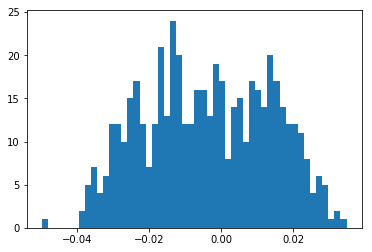

In [8]:
plt.hist(dense_weights[1:-1, 1:-1].ravel(), 50)

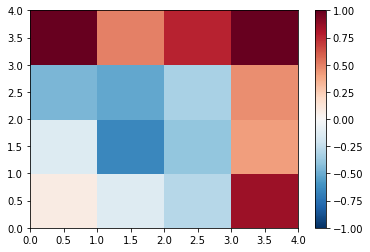

In [9]:
plt.pcolormesh(dense_weights.sum(axis=-1), vmin=-1, vmax=1, cmap="RdBu_r")
plt.colorbar()

In [15]:
np.unravel_index(12, (4,4))

(3, 0)

In [23]:
np.where(dense_weights > 0.02, 1, 0).sum(axis=-1).argmax()

12

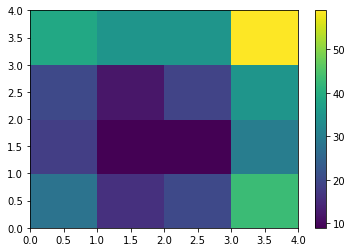

In [51]:
plt.pcolormesh(np.where(dense_weights > 0.02, 1, 0).sum(axis=-1))
plt.colorbar()

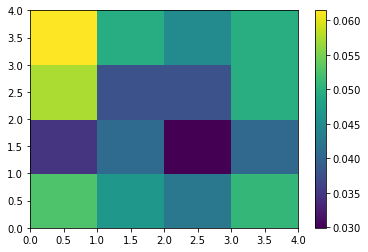

In [140]:
plt.pcolormesh(dense_weights.max(axis=-1))
plt.colorbar()

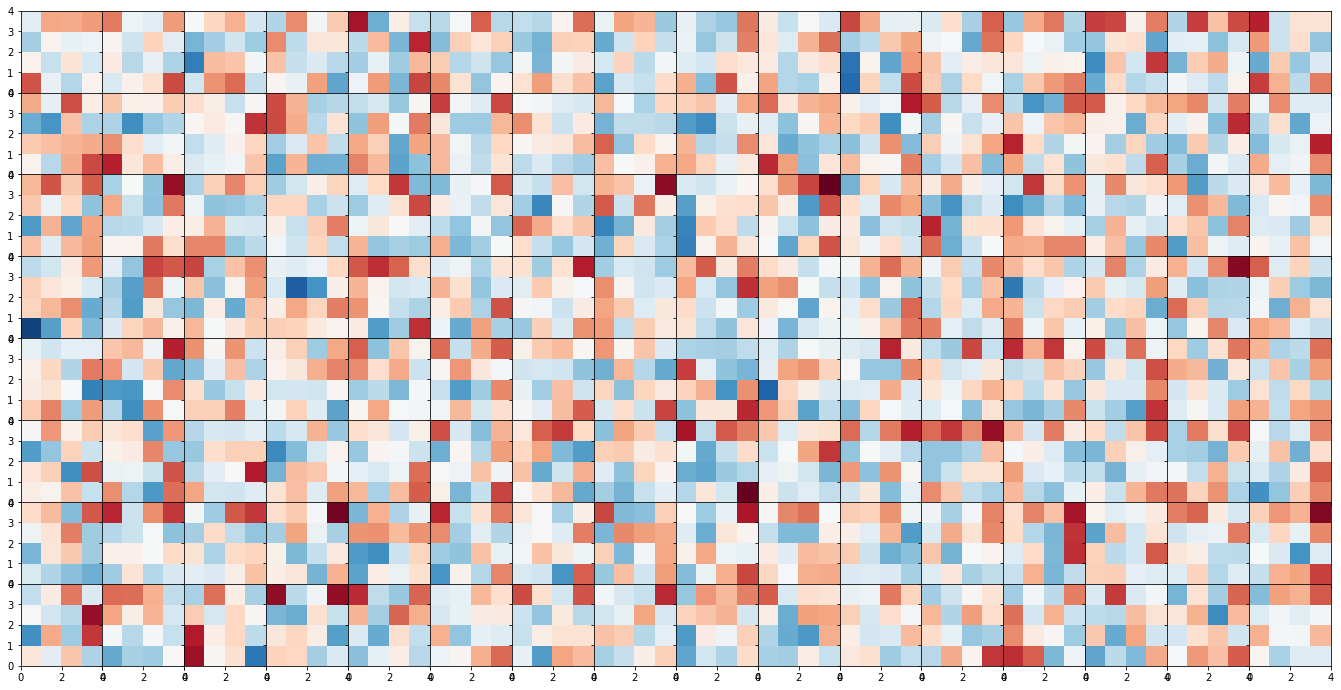

In [10]:
fig, axes = plt.subplots(8, 16, figsize=(20, 10), sharex=True, sharey=True)
plt.subplots_adjust(0.03, 0.03, 0.94, 0.94, hspace=0, wspace=0)
for a, ax in enumerate(axes.ravel()):
    ax.pcolormesh(dense_weights[:, :, a], vmin=-0.06, vmax=0.06, cmap="RdBu_r")

In [71]:
def activated_analogs(norm_data, cnn_model, num_analogs=16, filter_index=(0, 0), dense_layer_index=-2,
                      conv_layer_index=-6):
    """
    For a given convolutional neural network, identify the examples that most activate a given set of
    neurons in a convolutional layer.

    Args:
        norm_data: Normalized input data for the convolutional neural network
        cnn_model: Keras convolutional neural network model object
        num_analogs: Number of activated input examples to store for each neuron
        filter_index: Spatial array index of convolution filters being evaluated
        dense_layer_index: Index of the final dense layer that connects the convolutions and outputs
        conv_layer_index: Index of the activation of the final convolutional layer.

    Returns:
        dense_weights (array of weight values), top_analog_ids (input data indices associated with each neuron),
        top_analog_activations (the magnitude of the activation), top_analog_gradients (gradients with respect
        to the input for each of the top analogs)
    """
    dense_weights = pd.Series(cnn_model.layers[dense_layer_index].get_weights()[0].reshape(
        cnn_model.layers[conv_layer_index].output_shape[1:])[filter_index], name="Weights")
    top_analog_ids = pd.DataFrame(np.zeros((dense_weights.shape[-1], num_analogs), dtype=int),
                                  columns=["Analog_ID_{0:02d}".format(a) for a in range(num_analogs)])
    top_analog_activations = pd.DataFrame(np.zeros((dense_weights.shape[-1], num_analogs)),
                                          columns=["Analog_Act_{0:02d}".format(a) for a in range(num_analogs)])
    top_analog_gradients = np.zeros([dense_weights.shape[-1], num_analogs] + list(norm_data.shape[1:]))
    for w in range(dense_weights.shape[-1]):
        print(w, dense_weights[w])
        filter_out = cnn_model.layers[conv_layer_index].output[:, filter_index[0], filter_index[1], w]
        act_func = K.function([cnn_model.input, K.learning_phase()],
                              [filter_out])
        loss = (filter_out - 2) ** 2
        grad = K.gradients(loss, cnn_model.input)[0]
        grad /= K.maximum(K.std(grad), K.epsilon())
        grad_func = K.function([cnn_model.input, K.learning_phase()], [grad])
        max_acts = act_func([norm_data, 0])[0]
        top_analog_ids.loc[w] = np.argsort(max_acts)[::-1][:num_analogs]
        top_analog_activations.loc[w] = max_acts[top_analog_ids.loc[w]]
        top_analog_gradients[w] = grad_func([norm_data[top_analog_ids.loc[w]], 0])[0]
    combined_info = pd.concat([top_analog_ids, top_analog_activations, dense_weights], axis=1)
    return combined_info, top_analog_gradients

In [72]:
analog_info, analog_gradients = activated_analogs(storm_norm_data, hail_cnn, filter_index=(1, 1))

0 -0.013771823
1 -0.016664773
2 0.018412651
3 -0.014204214
4 -0.004878448
5 -0.017432041
6 -0.028050717
7 0.013670226
8 -0.01099966
9 -0.01769745
10 0.0020298182
11 -0.0063217413
12 -0.0032234164
13 0.017209124
14 0.015342723
15 0.01590437
16 0.018054202
17 0.010376171
18 -0.007422329
19 -0.008889999
20 0.014299571
21 -0.0021572066
22 0.00471891
23 -0.023546934
24 -0.017199207
25 -0.030310424
26 -0.0124488855
27 -0.0027411627
28 0.011502943
29 -0.020338662
30 0.015841624
31 -0.009848939
32 0.020852013
33 -0.01605926
34 0.020708364
35 -0.014048111
36 0.006849356
37 -0.023456397
38 0.022917919
39 -0.028413305
40 0.015478894
41 -0.013567386
42 -0.024912445
43 -0.02840139
44 0.008369038
45 0.021024337
46 0.016787654
47 -0.008739818
48 0.020127444
49 -0.033703852
50 0.004379493
51 0.022972299
52 0.0010101943
53 0.015707297
54 -0.0023341351
55 0.01573416
56 -0.012758902
57 5.9397462e-05
58 0.010740341
59 0.012729107
60 -0.013539034
61 0.011588308
62 0.015188462
63 -0.02914968
64 0.008732372


In [73]:
analog_info

,Analog_ID_00,Analog_ID_01,Analog_ID_02,Analog_ID_03,Analog_ID_04,Analog_ID_05,Analog_ID_06,Analog_ID_07,Analog_ID_08,Analog_ID_09,Analog_ID_10,Analog_ID_11,Analog_ID_12,Analog_ID_13,Analog_ID_14,Analog_ID_15,Analog_Act_00,Analog_Act_01,Analog_Act_02,Analog_Act_03,Analog_Act_04,Analog_Act_05,Analog_Act_06,Analog_Act_07,Analog_Act_08,Analog_Act_09,Analog_Act_10,Analog_Act_11,Analog_Act_12,Analog_Act_13,Analog_Act_14,Analog_Act_15,Weights
0,930,928,968,959,985,954,987,929,958,940,942,1015,1017,953,983,969,3.733038,3.563779,3.518764,3.517291,3.480559,3.449912,3.392570,3.374451,3.354702,3.342151,3.312269,3.293807,3.251610,3.239579,3.225788,3.214347,-0.013772
1,930,928,954,968,959,985,958,969,1015,929,953,940,942,1092,932,987,2.745308,2.743721,2.705004,2.704191,2.676445,2.627181,2.605394,2.599516,2.580738,2.578334,2.558153,2.548826,2.532811,2.480044,2.452216,2.429768,-0.016665
2,4678,9061,6938,6789,8156,6869,4661,9406,1391,4337,6775,8612,4012,2117,3076,3068,1.659934,1.610037,1.446346,1.445737,1.394271,1.317700,1.312231,1.302800,1.281997,1.244865,1.238533,1.217283,1.179079,1.143356,1.142889,1.134442,0.018413
3,960,954,953,969,1015,940,931,942,968,961,988,958,932,930,941,944,2.217081,2.193637,2.189465,2.165524,2.159640,2.145618,2.025946,1.993283,1.989491,1.971538,1.968788,1.965174,1.951091,1.936292,1.917695,1.915399,-0.014204
4,928,930,959,985,968,954,929,987,958,942,973,940,1017,932,991,974,2.689923,2.671267,2.669304,2.589245,2.577738,2.539871,2.508323,2.508306,2.503057,2.410481,2.392250,2.392038,2.387847,2.384932,2.378027,2.375983,-0.004878
5,6542,10765,10767,3011,358,10771,10983,326,10766,8928,8409,8485,10738,8375,8817,8532,1.810634,1.598184,1.573003,1.528904,1.521616,1.517914,1.500517,1.487134,1.479785,1.474902,1.471731,1.470371,1.462471,1.461381,1.457018,1.455395,-0.017432
6,930,959,928,985,929,954,958,1252,968,1092,4466,942,987,983,1015,943,2.766064,2.724615,2.693931,2.684094,2.584000,2.516263,2.450152,2.446223,2.440851,2.419864,2.400708,2.399326,2.391753,2.381631,2.377800,2.365341,-0.028051
7,8928,6542,8817,358,326,6452,8820,4323,8871,8932,5483,8873,356,8870,5482,8922,2.518646,2.463715,2.387751,2.376602,2.307577,2.272052,2.268550,2.204990,2.166622,2.148407,2.142189,2.135883,2.101009,2.066568,2.055952,2.030185,0.013670
8,930,928,959,985,954,968,929,1015,987,940,942,958,969,953,1092,983,3.639256,3.600932,3.578814,3.537729,3.488015,3.485750,3.467543,3.394353,3.363127,3.360795,3.356622,3.337414,3.283337,3.279181,3.247297,3.237773,-0.011000
9,8485,8532,10724,10767,10744,10763,8426,8530,10727,10766,10797,10699,10794,10771,10838,10714,3.409849,3.402233,3.318634,3.287725,3.209500,3.192662,3.190978,3.177582,3.167682,3.131830,3.125854,3.107516,3.063658,3.034455,3.025093,3.020772,-0.017697


104    0.023381
51     0.022972
38     0.022918
112    0.022721
72     0.021976
45     0.021024
32     0.020852
34     0.020708
48     0.020127
83     0.018656
2      0.018413
16     0.018054
102    0.017466
13     0.017209
46     0.016788
15     0.015904
30     0.015842
55     0.015734
53     0.015707
40     0.015479
14     0.015343
119    0.015270
62     0.015188
20     0.014300
80     0.014081
7      0.013670
73     0.013123
115    0.013066
59     0.012729
108    0.011689
         ...   
98    -0.018986
29    -0.020339
70    -0.020948
66    -0.022611
37    -0.023456
23    -0.023547
117   -0.023817
101   -0.024369
87    -0.024438
90    -0.024749
71    -0.024775
42    -0.024912
103   -0.026975
99    -0.027146
6     -0.028051
93    -0.028173
43    -0.028401
39    -0.028413
107   -0.028464
63    -0.029150
121   -0.030057
86    -0.030105
125   -0.030241
25    -0.030310
116   -0.030411
88    -0.031509
69    -0.033407
49    -0.033704
65    -0.034704
100   -0.037076
Name: Weights, Length: 1

/users/dgagne/miniconda3/envs/deep/lib/python3.6/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


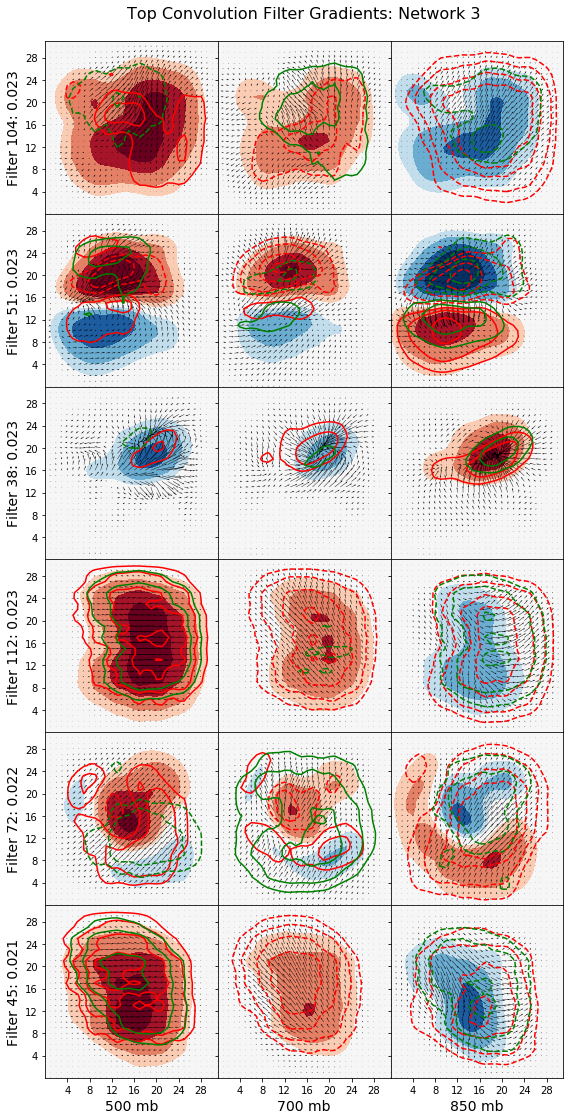

In [91]:
fig, axes = plt.subplots(6, 3, figsize=(8, 16), sharex=True, sharey=True)
plt.subplots_adjust(0.05, 0.05, 0.95, 0.95, wspace=0, hspace=0)
contours = [-3, -2, -1, -0.5, 0.5, 1, 2, 3]
ranked_weights = analog_info["Weights"].sort_values()[::-1].index
p_levels = [500, 700, 850]
for (w,a), ax in np.ndenumerate(axes):
    weight = ranked_weights[w]
    ax.contourf(gaussian_filter(analog_gradients[weight, :, :, :, 0 + a].mean(axis=0), 1), contours, extend="both", cmap="RdBu_r")
    ax.contour(gaussian_filter(analog_gradients[weight, :, :, :, 3 + a].mean(axis=0), 1), contours, colors="red")
    ax.contour(gaussian_filter(analog_gradients[weight, :, :, :, 6 + a].mean(axis=0), 1), contours, colors="green")
    ax.quiver(gaussian_filter(analog_gradients[weight, :, :, :, 9 + a].mean(axis=0), 1),
             gaussian_filter(analog_gradients[weight, :, :, :, 12 + a].mean(axis=0), 1))
    if a == 0:
        ax.set_ylabel("Filter {0:02d}: {1:0.3f}".format(ranked_weights[w], analog_info.loc[ranked_weights[w], "Weights"]),
                  fontsize=14)
    ax.set_yticks(np.arange(4, 32, 4))
    ax.set_xticks(np.arange(4, 32, 4))
    if w == 5:
        ax.set_xlabel("{0:d} mb".format(p_levels[a]), fontsize=14)
    #ax.set_xlim(0, 16)
    #ax.set_ylim(16, 31)
plt.suptitle("Top Convolution Filter Gradients: Network {0:d}".format(sample), fontsize=16)
plt.savefig("top_filter_gradients_{0:02d}.png".format(sample), dpi=300, bbox_inches="tight")

array([ 958.,  914.,  928.,  952.,  943.,  972.,  956.,  932., 4477.,
        959., 4003.,  930., 1018.,  931.,  941.,  929.])

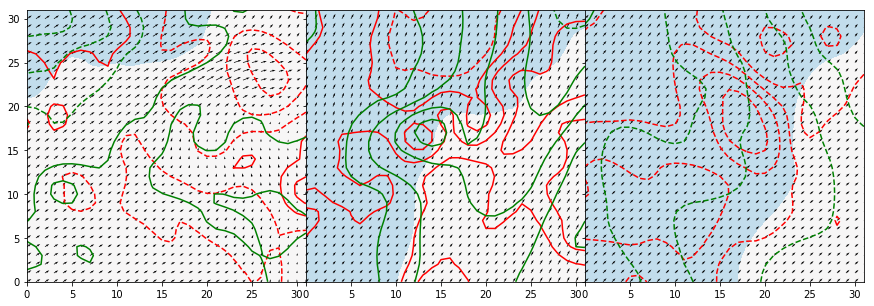

In [70]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0, hspace=0.05)
contours = [-3, -2, -1, -0.5, 0.5, 1, 2, 3]
weight = 97
weight_analogs = analog_info.iloc[weight, 0:16].values.astype(int)
for a, ax in enumerate(axes):
    ax.contourf(gaussian_filter(storm_norm_data[weight_analogs, :, :, 0 + a][1], 1), contours, extend="both", cmap="RdBu_r")
    ax.contour(gaussian_filter(storm_norm_data[weight_analogs, :, :, 3 + a][1], 1), 5, colors="red")
    ax.contour(gaussian_filter(storm_norm_data[weight_analogs, :, :, 6 + a][1], 1), 5, colors="green")
    ax.quiver(gaussian_filter(storm_norm_data[weight_analogs, :, :, 9 + a][1], 1),
             gaussian_filter(storm_norm_data[weight_analogs, :, :, 12 + a][1], 1))

In [16]:
num_ex = 16
top_max_example_ids = np.zeros((dense_weights.shape[-1], num_ex), dtype=int)
top_max_acts = np.zeros((dense_weights.shape[-1], num_ex))
top_max_gradients = np.zeros((dense_weights.shape[-1], num_ex, 32, 32, 15))

for w in range(dense_weights.shape[-1]):
    print(w)
    act_func = K.function([hail_cnn.input, K.learning_phase()], 
                          [hail_cnn.layers[-6].output[:, 3, 0, w]])
    max_loss = (hail_cnn.layers[-6].output[:, 3, 0, w]- 4) ** 2
    max_grad = K.gradients(max_loss, hail_cnn.input)
    max_grad_func = K.function([hail_cnn.input, K.learning_phase()], max_grad)
    max_acts = act_func([storm_norm_data, 0])[0]
    top_max_example_ids[w] = np.argsort(max_acts)[::-1][:num_ex]
    top_max_acts[w] = max_acts[top_max_example_ids[w]]
    top_max_gradients[w] = max_grad_func([storm_norm_data[top_max_example_ids[w]]])[0]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127


In [35]:
hail_cnn.layers[-6].output[:, :, :, 4]

<tf.Tensor 'strided_slice_129:0' shape=(?, 4, 4) dtype=float32>

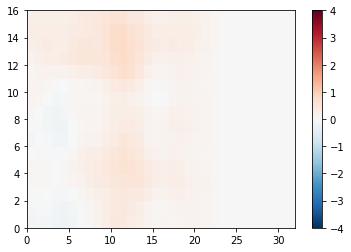

In [134]:
plt.pcolormesh(gaussian_filter(top_max_gradients[63,:, :, :, 2].mean(axis=1) / top_max_gradients[63].std(), 1), 
               vmin=-4, vmax=4, cmap="RdBu_r")
plt.colorbar()

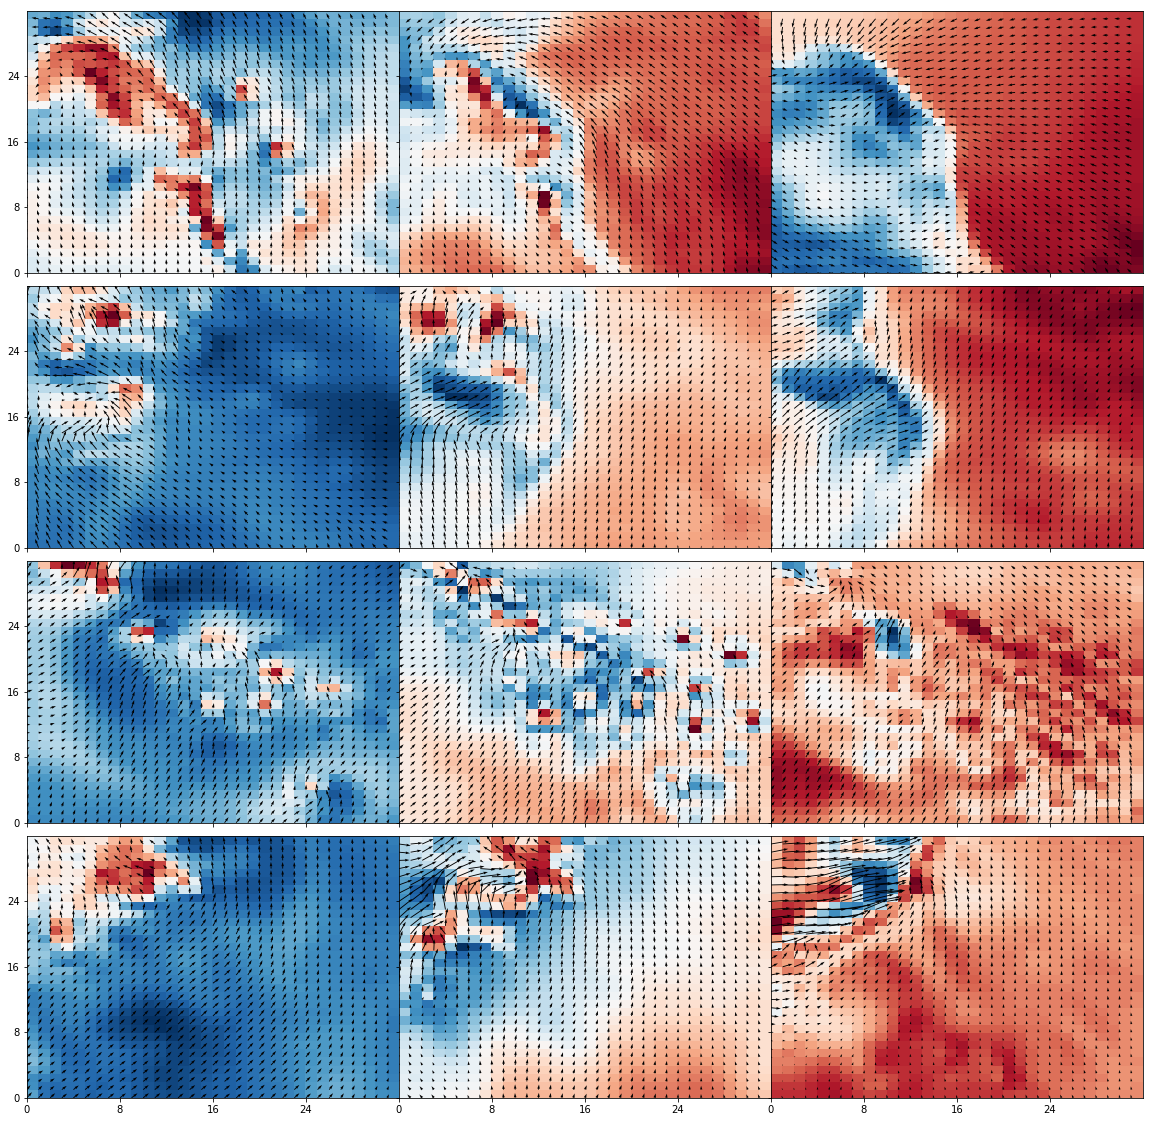

In [25]:
fig, axes = plt.subplots(4, 3, figsize=(20, 20), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0, hspace=0.05)
contours = np.array([-3, -2.5, -2, -1.5, -1, -0.5, 0.5, 1, 1.5, 2, 2.5, 3])
for w, ex_id in enumerate(top_max_example_ids[42][:4]):
    for l in range(3):
        axes[w, l].pcolormesh(storm_norm_data[ex_id, :, :, 3 + l], cmap="RdBu_r")
        #axes[w, l].contour(storm_norm_data[ex_id, :, :, 3 + l], contours, colors="red")
        #axes[w, l].contour(storm_norm_data[ex_id, :, :, 6 + l], contours, colors="green")
        axes[w, l].quiver(storm_norm_data[ex_id, :, :, 9 + l], storm_norm_data[ex_id, :, :, 12 + l])
        axes[w, l].set_yticks(np.arange(0, 32, 8))
        axes[w, l].set_xticks(np.arange(0, 32, 8))

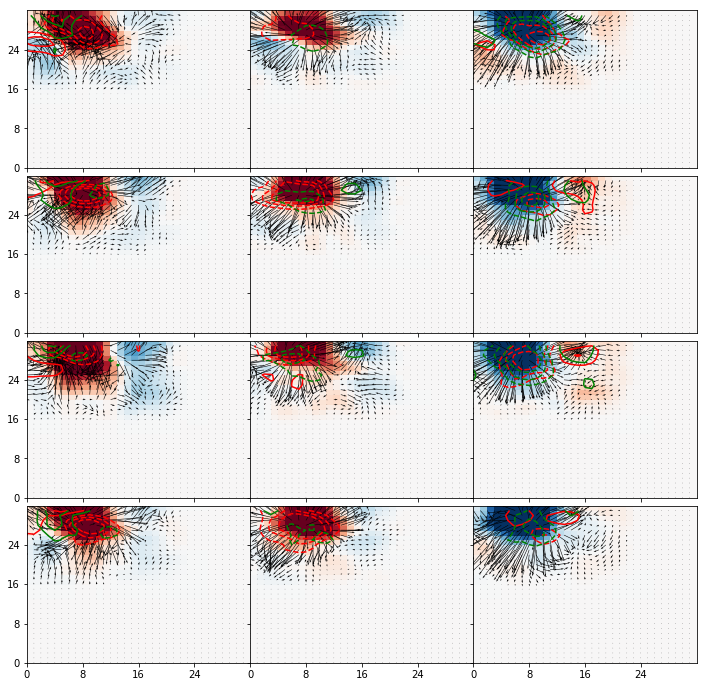

In [26]:
fig, axes = plt.subplots(4, 3, figsize=(12, 12), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0, hspace=0.05)
contours = np.array([-3, -2, -1, 1, 2, 3])
c_filter = 42
for w, ex_id in enumerate(top_max_example_ids[c_filter][:4]):
    scale = top_max_gradients[c_filter, w].std()
    for l in range(3):
        axes[w, l].pcolormesh(gaussian_filter(top_max_gradients[c_filter, w, :, :, 0 + l] / scale, 1), vmin=-3, vmax=3, cmap="RdBu_r")
        axes[w, l].contour(gaussian_filter(top_max_gradients[c_filter, w, :, :, 3 + l] / scale, 1), contours, colors="red")
        axes[w, l].contour(gaussian_filter(top_max_gradients[c_filter, w, :, :, 6 + l]/ scale, 1), contours, colors="green")
        axes[w, l].quiver(gaussian_filter(top_max_gradients[c_filter, w, :, :, 9 + l] / scale, 1) , 
                          gaussian_filter(top_max_gradients[c_filter, w, :, :, 12 + l] / scale,1))
        axes[w, l].set_yticks(np.arange(0, 32, 8))
        axes[w, l].set_xticks(np.arange(0, 32, 8))

ValueError: too many values to unpack (expected 2)

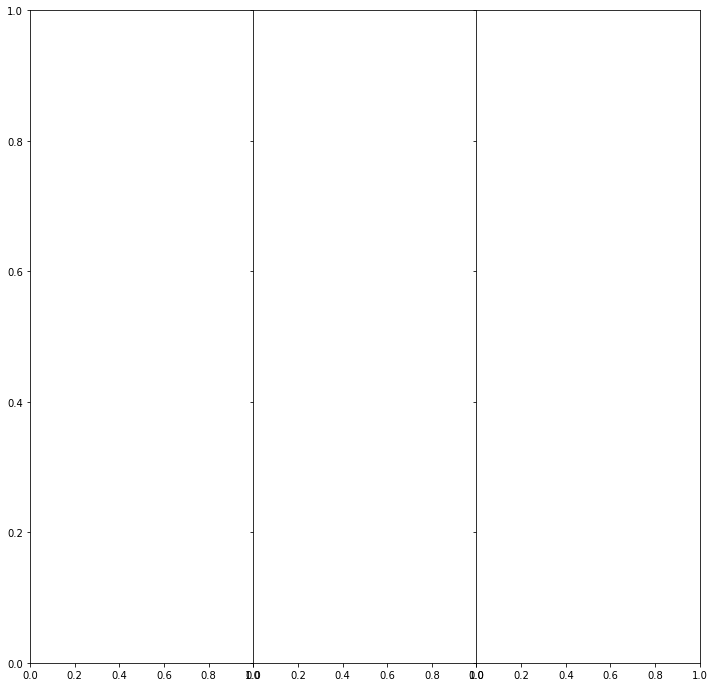

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(12, 12), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0, hspace=0.05)
contours = np.array([-3, -2, -1, 1, 2, 3])
c_filter = 42
scale = top_max_gradients[c_filter].std()
w = 0
for l in range(3):
    axes[l].pcolormesh(gaussian_filter(top_max_gradients[c_filter, :, :, :, 0 + l] / scale, 1), vmin=-3, vmax=3, cmap="RdBu_r")
    axes[l].contour(gaussian_filter(top_max_gradients[c_filter, :, :, :, 3 + l].mean(axis=0) / scale, 1), contours, colors="red")
    axes[l].contour(gaussian_filter(top_max_gradients[c_filter, :, :, :, 6 + l].mean(axis=0)/ scale, 1), contours, colors="green")
    axes[l].quiver(gaussian_filter(top_max_gradients[c_filter, :, :, :, 9 + l].mean(axis=1) / scale, 1) , 
                      gaussian_filter(top_max_gradients[c_filter, :, :, :, 12 + l].mean(axis=1) / scale,1))
    axes[l].set_yticks(np.arange(0, 32, 8))
    axes[l].set_xticks(np.arange(0, 32, 8))

In [146]:
dense_weights[0, 0].argmax()

90

In [86]:
top_max_example_ids[63]

array([4477, 4468, 4476, 4469,  959,  960, 4466, 5119,  930,  958, 1017,
        975,  928,  990,  961,  929])

In [138]:
top_max_gradients[0, w, :, :, 9 + l].shape

(32, 32)